In [99]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB
import requests
from datetime import datetime

In [59]:
def input_passenger():
    while(True):
        type = input('목적지 동일 => insert: A\n 출발지 동일 => insert: B\n\n>>').upper()
        if type=="A" or type=="B":
            pass
        else:
            print('잘못된 입력입니다.')
            break
        passenger_number = int(input('탑승자 수 입력 (2명~4명)\n\n>> '))
        if 2<=passenger_number<=4:
            total = []
            dst = []
            if type=="A":
                for i in range(passenger_number):
                    total.append(input(f'탑승자 {i+1}의 출발지 입력 >> '))
                dst.append(input(f'최종 목적지 입력 >> '))
            else:
                total.append(input(f'최초 출발지 입력 >> '))
                for i in range(passenger_number):
                    dst.append(input(f'탑승자 {i+1}의 목적지 입력 >> '))
            src = total.copy()
            total.extend(dst)
            loc_info = {i :[total[i]] for i in range(len(total))}
            return type, passenger_number, src, dst, loc_info
            break
        else:
            print('잘못된 입력입니다')
            break

In [61]:
type, passenger_number, src, dst, loc_info = input_passenger()
print(src, dst)
print(loc_info)

['안암역', '노원역', '한양대역'] ['서울역']
{0: ['안암역'], 1: ['노원역'], 2: ['한양대역'], 3: ['서울역']}


In [85]:
### routing TYPE A

def routing_type_a(loc_info, eplison,gamma,LB,UB):
    loc_info = loc_info

    for i in range(len(loc_info)):
        url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchType=all" \
              f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

        headers = {
            "Accept": "application/json",
            "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
        }

        response = requests.get(url, headers=headers)
        jsonObj = json.loads(response.text)
        loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
        loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))

    addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
    passenger_sample = addr_info.keys()
    if len(loc_info)==3: # 동승자 2명
        a,b,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', dst: 'dst'}
    elif len(loc_info)==4: # 동승자 3명
        a,b,c,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'c': c, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', c: 'c', dst: 'dst'}
    elif len(loc_info)==5: # 동승자 2명
        a,b,c,d,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'c': c, 'd': d, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', c: 'c', d: 'd', dst: 'dst'}

    lat = [addr_info[addr]['lat'] for addr in passenger_sample]
    lon = [addr_info[addr]['lon'] for addr in passenger_sample]
    addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

    def dist(addr):
        return ((addr_info[addr]['lat']-loc_info[len(loc_info)-1][2])**2 + (addr_info[addr]['lon']-loc_info[len(loc_info)-1][1])**2)**1/2

    rout = [[addr,dist(addr)] for addr in passenger_sample]
    rout.sort(key=lambda  x: x[1], reverse=True)

    routing = {addr: {'node':node_2_pass[addr],'no':addr_info[addr]['no']} for addr,dis in rout}
    passenger_routing = list(routing.keys())

    lat2 = [addr_info[rou]['lat'] for rou in routing]
    lon2 = [addr_info[rou]['lon'] for rou in routing]

    fig, ax = plt.subplots()
    ax.scatter(lon, lat)
    for i, txt in enumerate(routing):
        try:
            ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
        except: pass
    for i, txt in enumerate(addr):
        ax.annotate(txt, (lon[i], lat[i]))
    plt.show()
    print(passenger_routing)

    individual_distance = []
    individual_duration = []
    individual_cost = []


    url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

    for i in range(len(loc_info)-1):
        payload = {
            "tollgateFareOption": 16,
            "roadType": 32,
            "directionOption": 1,
            "endX": addr_info[passenger_routing[-1]]['lon'],
            "endY": addr_info[passenger_routing[-1]]['lat'],
            "endRpFlag": "G",
            "reqCoordType": "WGS84GEO",
            "startX": addr_info[passenger_routing[i]]['lon'],
            "startY": addr_info[passenger_routing[i]]['lat'],
            "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
            "speed": 10,
            "uncetaintyP": 1,
            "uncetaintyA": 1,
            "uncetaintyAP": 1,
            "carType": 0,
            "detailPosFlag": "2",
            "resCoordType": "WGS84GEO",
            "sort": "index",
            "searchOption": 0,
            "totalValue": 2,
            "trafficInfo": "N",
            "mainRoadInfo": "N"
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
        }

        response = requests.post(url, json=payload, headers=headers)
        jsonObj = json.loads(response.text)

        individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
        individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
        individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

    routing_distance = []
    routing_duration = []
    routing_cost = []

    url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

    for j in range(1,len(loc_info)-1):
        passlist = ''
        for i in range(j,len(loc_info)-1):
            if i==len(loc_info)-1:
                break
            passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
            if i!=len(loc_info)-2:
                passlist += '_'

        payload = {
            "tollgateFareOption": 16,
            "roadType": 32,
            "directionOption": 1,
            "endX": addr_info[passenger_routing[-1]]['lon'],
            "endY": addr_info[passenger_routing[-1]]['lat'],
            "endRpFlag": "G",
            "reqCoordType": "WGS84GEO",
            "startX": addr_info[passenger_routing[j-1]]['lon'],
            "startY": addr_info[passenger_routing[j-1]]['lat'],
            "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
            "speed": 10,
            "uncetaintyP": 1,
            "uncetaintyA": 1,
            "uncetaintyAP": 1,
            "carType": 0,
            "passList": passlist,
            "detailPosFlag": "2",
            "resCoordType": "WGS84GEO",
            "sort": "index",
            "mainRoadInfo": "N",
            "trafficInfo": "N",
            "totalValue": 2
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "appKey": "e8wHh2tya84M88aReEpXCa5XTQf3xgo01aZG39k5"
        }

        response = requests.post(url, json=payload, headers=headers)
        jsonObj = json.loads(response.text)

        routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
        routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
        routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

    routing_distance.append(individual_distance[-1])
    routing_duration.append(individual_duration[-1])
    routing_cost.append((individual_cost[-1]))

    delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]

    ### optimize
    T = routing_cost[0]
    eplison = eplison
    gamma = gamma

    LB = LB
    UB = UB

    if len(loc_info)==3: # 동승자 2명
        I1, I2 = individual_cost
        R1, R2 = delay_ratio
        ## matching ALGorithm
        try:
          # Create a new model
          m = gp.Model('cost_optimization1')

          # Create variables
          alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
          beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

          # Set objective
          m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T, GRB.MINIMIZE)

          # Add constraint
          m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
          m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
          m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T >= 0,'const_3')

          m.addConstr(alpha <= 0.5)
          m.addConstr(alpha >= 0)
          m.addConstr(beta <= 0.5)
          m.addConstr(beta >= 0)
          #m.addConstr(gamma <= 1)

          # Optimize model
          m.optimize()

          for v in m.getVars():
            # print('%s : %g' % (v.varName, v.x))
            globals()[v.varName] = v.x
          # print('Obj : %g' % m.objVal)

        except gp.GurobiError as e:
          print('Error code ' + str(e.errno) + ': ' + str(e))

    elif len(loc_info)==4: # 동승자 3명
        I1, I2, I3 = individual_cost
        R1, R2, R3 = delay_ratio
        ## matching ALGorithm
        try:
          # Create a new model
          m = gp.Model('cost_optimization1')

          # Create variables
          alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
          beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

          # Set objective
          m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T, GRB.MINIMIZE)

          # Add constraint
          m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
          m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
          m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T >= 0,'const_3')

          m.addConstr(alpha <= 0.5)
          m.addConstr(alpha >= 0)
          m.addConstr(beta <= 0.5)
          m.addConstr(beta >= 0)
          #m.addConstr(gamma <= 1)

          # Optimize model
          m.optimize()

          for v in m.getVars():
            # print('%s : %g' % (v.varName, v.x))
            globals()[v.varName] = v.x
          # print('Obj : %g' % m.objVal)

        except gp.GurobiError as e:
          print('Error code ' + str(e.errno) + ': ' + str(e))

    elif len(loc_info)==5: # 동승자 4명
        I1, I2, I3, I4 = individual_cost
        R1, R2, R3, R4 = delay_ratio
        ## matching ALGorithm
        try:
          # Create a new model
          m = gp.Model('cost_optimization1')
          m.Params.LogToConsole = 0

          # Create variables
          alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
          beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

          # Set objective
          m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T, GRB.MINIMIZE)

          # Add constraint
          m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
          m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
          m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T >= 0,'const_3')

          m.addConstr(alpha <= 0.5)
          m.addConstr(alpha >= 0)
          m.addConstr(beta <= 0.5)
          m.addConstr(beta >= 0)
          #m.addConstr(gamma <= 1)

          # Optimize model
          m.optimize()

          for v in m.getVars():
            # print('%s : %g' % (v.varName, v.x))
            globals()[v.varName] = v.x
          # print('Obj : %g' % m.objVal)

        except gp.GurobiError as e:
          print('Error code ' + str(e.errno) + ': ' + str(e))

    if len(loc_info)==3:
        routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2)]
    elif len(loc_info)==4:
        routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2),int((1-alpha+beta*R3)*I3)]
    elif len(loc_info)==5:
        routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2),int((1-alpha+beta*R3)*I3),int((1-alpha+beta*R4)*I4)]

    return passenger_routing, routing_individual_cost, routing_duration, routing_distance, individual_cost, individual_duration, individual_distance, alpha, beta

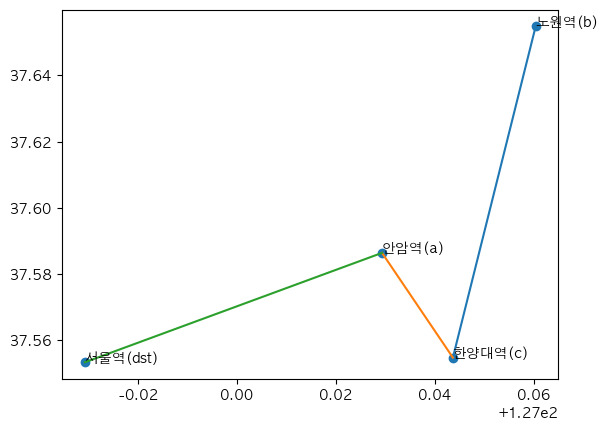

['노원역', '한양대역', '안암역', '서울역']


In [96]:
def indiviual_type_a(loc_info):
    loc_info = loc_info
    for i in range(len(loc_info)):
        url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchType=all" \
              f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

        headers = {
            "Accept": "application/json",
            "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
        }

        response = requests.get(url, headers=headers)
        jsonObj = json.loads(response.text)
        loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
        loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))

    addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
    passenger_sample = addr_info.keys()
    if len(loc_info)==3: # 동승자 2명
        a,b,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', dst: 'dst'}
    elif len(loc_info)==4: # 동승자 3명
        a,b,c,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'c': c, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', c: 'c', dst: 'dst'}
    elif len(loc_info)==5: # 동승자 2명
        a,b,c,d,dst = passenger_sample
        pass_2_node = {'a': a, 'b': b, 'c': c, 'd': d, 'dst':dst}
        node_2_pass = {a: 'a', b: 'b', c: 'c', d: 'd', dst: 'dst'}

    lat = [addr_info[addr]['lat'] for addr in passenger_sample]
    lon = [addr_info[addr]['lon'] for addr in passenger_sample]
    addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

    def dist(addr):
        return ((addr_info[addr]['lat']-loc_info[len(loc_info)-1][2])**2 + (addr_info[addr]['lon']-loc_info[len(loc_info)-1][1])**2)**1/2

    rout = [[addr,dist(addr)] for addr in passenger_sample]
    rout.sort(key=lambda  x: x[1], reverse=True)

    routing = {addr: {'node':node_2_pass[addr],'no':addr_info[addr]['no']} for addr,dis in rout}
    passenger_routing = list(routing.keys())

    lat2 = [addr_info[rou]['lat'] for rou in routing]
    lon2 = [addr_info[rou]['lon'] for rou in routing]

    fig, ax = plt.subplots()
    ax.scatter(lon, lat)
    for i, txt in enumerate(routing):
        try:
            ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
        except: pass
    for i, txt in enumerate(addr):
        ax.annotate(txt, (lon[i], lat[i]))
    plt.show()
    print(passenger_routing)

    individual_distance = []
    individual_duration = []
    individual_cost = []


    url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

    for i in range(len(loc_info)-1):
        payload = {
            "tollgateFareOption": 16,
            "roadType": 32,
            "directionOption": 1,
            "endX": addr_info[passenger_routing[-1]]['lon'],
            "endY": addr_info[passenger_routing[-1]]['lat'],
            "endRpFlag": "G",
            "reqCoordType": "WGS84GEO",
            "startX": addr_info[passenger_routing[i]]['lon'],
            "startY": addr_info[passenger_routing[i]]['lat'],
            "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
            "speed": 10,
            "uncetaintyP": 1,
            "uncetaintyA": 1,
            "uncetaintyAP": 1,
            "carType": 0,
            "detailPosFlag": "2",
            "resCoordType": "WGS84GEO",
            "sort": "index",
            "searchOption": 0,
            "totalValue": 2,
            "trafficInfo": "N",
            "mainRoadInfo": "N"
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
        }

        response = requests.post(url, json=payload, headers=headers)
        jsonObj = json.loads(response.text)

        individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
        individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
        individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

        return_dict = dict()

        return

In [ ]:
def routing_type_a():
    routing_distance = []
    routing_duration = []
    routing_cost = []

    url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

    for j in range(1,len(loc_info)-1):
        passlist = ''
        for i in range(j,len(loc_info)-1):
            if i==len(loc_info)-1:
                break
            passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
            if i!=len(loc_info)-2:
                passlist += '_'

        payload = {
            "tollgateFareOption": 16,
            "roadType": 32,
            "directionOption": 1,
            "endX": addr_info[passenger_routing[-1]]['lon'],
            "endY": addr_info[passenger_routing[-1]]['lat'],
            "endRpFlag": "G",
            "reqCoordType": "WGS84GEO",
            "startX": addr_info[passenger_routing[j-1]]['lon'],
            "startY": addr_info[passenger_routing[j-1]]['lat'],
            "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
            "speed": 10,
            "uncetaintyP": 1,
            "uncetaintyA": 1,
            "uncetaintyAP": 1,
            "carType": 0,
            "passList": passlist,
            "detailPosFlag": "2",
            "resCoordType": "WGS84GEO",
            "sort": "index",
            "mainRoadInfo": "N",
            "trafficInfo": "N",
            "totalValue": 2
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "appKey": "e8wHh2tya84M88aReEpXCa5XTQf3xgo01aZG39k5"
        }

        response = requests.post(url, json=payload, headers=headers)
        jsonObj = json.loads(response.text)

        routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
        routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
        routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

    routing_distance.append(individual_distance[-1])
    routing_duration.append(individual_duration[-1])
    routing_cost.append((individual_cost[-1]))

    delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]

In [98]:
total = ['안암역','노원역','한양대역']#,'성신여대역']
dst = ['서울역']
src = total.copy()
total.extend(dst)
loc_info = {i :[total[i]] for i in range(len(total))}

indiviual_type_a(loc_info)